In [1]:
from spice.models.binary import Binary, add_orbit, evaluate_orbit_at_times
from spice.models.mesh_model import IcosphereModel
from spice.models.mesh_view import get_mesh_view
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from spice.spectrum import simulate_observed_flux
from transformer_payne import Blackbody
import jax.numpy as jnp
%matplotlib inline

from jax import config
config.update('jax_platform_name', 'cpu')

In [2]:
def default_icosphere(radius=1):
    return get_mesh_view(IcosphereModel.construct(100, radius, 1., [5700, 0.], ['teff', 'abun']), jnp.array([0., 1., 0.]))

body1 = default_icosphere()
body2 = default_icosphere(0.5)
binary = Binary.from_bodies(body1, body2)
binary = add_orbit(binary, 1., 0., 0., 0., 0., 0., 10, 0., 0., 20)
# times = jnp.linspace(0.245, 0.255, 10)
# pb1, pb2 = evaluate_orbit_at_times(binary, times)

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


In [3]:
body2.cast_centers

Array([[-0.2755667 , -0.07008567],
       [-0.34843048, -0.14916074],
       [-0.22178182, -0.19753623],
       [-0.28590906, -0.14097324],
       [-0.40256095, -0.2755667 ],
       [-0.31503958, -0.34843048],
       [-0.39331275, -0.22178182],
       [-0.37548432, -0.28590906],
       [-0.07008566, -0.40256095],
       [-0.14916073, -0.31503958],
       [-0.19753623, -0.39331275],
       [-0.14097323, -0.37548432],
       [-0.34749886, -0.22035462],
       [-0.2689194 , -0.34749886],
       [-0.22035462, -0.2689194 ],
       [-0.28355026, -0.28355026],
       [-0.20548102, -0.04331532],
       [-0.15089422, -0.1704596 ],
       [-0.07262106, -0.04381093],
       [-0.14493582, -0.08712626],
       [ 0.        , -0.3757906 ],
       [ 0.07827317, -0.2879629 ],
       [-0.07827317, -0.2879629 ],
       [ 0.        , -0.32163733],
       [ 0.20548102, -0.04331532],
       [ 0.07262106, -0.04381093],
       [ 0.15089422, -0.1704596 ],
       [ 0.14493582, -0.08712626],
       [-0.07857947,

In [4]:
np.argmin(np.abs(np.cumsum(np.sort(body2.cast_areas[body2.mus > 0])) - np.max(body1.cast_areas[body1.mus > 0])))

30

In [5]:
times = jnp.linspace(0.15706372, 0.1598338, 5)
pb1, pb2 = evaluate_orbit_at_times(binary, times)

n_neighbours1: 30, n_neighbours2: 2


In [6]:
times[13]

Array(0.1598338, dtype=float32)

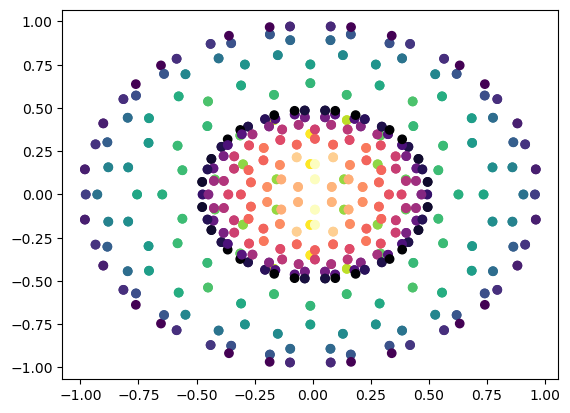

In [7]:
i = 2
plt.scatter(pb1[i].cast_centers[:, 0], pb1[i].cast_centers[:, 1], c=pb1[i].cast_areas, cmap='viridis')
plt.scatter(pb2[i].cast_centers[:, 0], pb2[i].cast_centers[:, 1], c=pb2[i].cast_areas, cmap='magma')

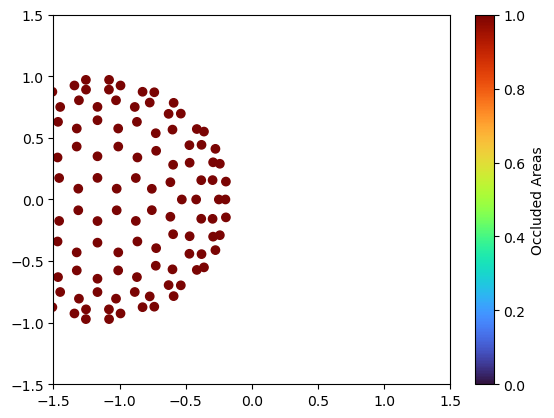

In [8]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

all_visible_cast_areas = jnp.concatenate([pb1[i].visible_cast_areas[pb1[i].mus > 0] / pb1[i].cast_areas[pb1[i].mus > 0] for i in range(len(times))])

sc = ax.scatter(pb1[0].cast_centers[pb1[0].mus > 0, 0], pb1[0].cast_centers[pb1[0].mus > 0, 1],
                c=pb1[0].visible_cast_areas[pb1[0].mus > 0] / pb1[0].cast_areas[pb1[0].mus > 0], cmap='turbo')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Occluded Areas')
sc.set_clim(vmin=all_visible_cast_areas.min(), vmax=all_visible_cast_areas.max())

def update(i):
    sc.set_offsets(pb1[i].cast_centers[pb1[i].mus > 0, :])
    sc.set_array(pb1[i].visible_cast_areas[pb1[i].mus > 0] / pb1[i].cast_areas[pb1[i].mus > 0])
    return sc,

ani = FuncAnimation(fig, update, frames=len(times), interval=500, blit=True)
plt.show()
ani.save('occlusion_debugging.gif')